# Investigating High Traffic Indicators on Westbound I-94

Interstate 94, or I-94, serves as a crucial artery in the American Midwest, spanning an impressive 1,585 miles from Billings, Montana, to Port Huron, Michigan. In this project, we delve into an in-depth analysis in uncovering traffic patterns along the westbound I-94. Our investigation encompasses a range of key factors, including:

* Weather conditions, such as weather types, rain, snow, and cloud cover.
* Time of the day, week, month, and other temporal variables.
* Temperature.
* U.S. Holidays.

Why focus on I-94? Several compelling factors underscore the significance of I-94's analysis valuable for improving the overall safety and efficiency in the highway: 
* **Strategic Connectivity:** I-94 serves as a vital conduit connecting seven major cities, including the bustling metropolises of Minneapolis-St. Paul, Milwaukee, and Chicago.
* **Economic Implications:** The movement of goods and people along I-94 fuels economic activity, linking major population centers, industrial hubs, and distribution facilities. Understanding traffic dynamics is essential for optimizing logistical operations and enhancing economic efficiency.
* **Traffic Challenges:** By dissecting the notorious high traffic volume along the stretch between Minneapolis and St. Paul, we aim to glean insights that can inform targeted interventions to alleviate congestion and enhance roadway safety.

**Use Case:** By leveraging the findings of this analysis, stakeholders can gain a deeper understanding of typical traffic volume on I-94, accurately predict high traffic on a given day, week, month, or holiday, and make informed decisions regarding route planning, resource allocation, and infrastructure investments. 

From transportation authorities seeking to optimize traffic management strategies to commuters wanting to navigate congested thoroughfares more effectively, the insights gleaned from this investigation hold the potential to drive tangible improvements in roadway efficiency and safety.

## Finding the Right Dataset
To conduct our analysis, we identified  a suitable [dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) published by John Hogue in the UC Irvine Machine Learning Repository. This dataset offers a comprehensive record of hourly traffic volume from Minneapolis to St. Paul, spanning the years 2012 to 2018. Given the dataset's granularity and coverage, it provides an ideal foundation for our investigation into traffic patterns along this critical corridor.

It's important to note that since the dataset pertains to traffic flowing from Minneapolis to St. Paul (*east to west*), we will focus of our analysis exclusively on I-94 *Westbound* traffic between *Minneapolis to St.Paul* to avoid generalization. This allows us to hone in on the segment of the interstate that is renowned for its high traffic volume, ensuring that our findings remain relevant and actionable without sacrificing specificity.

<center><img src=".\images\i94_map.jpg" alt="I-94 Map" width="500" height="300"></center>

In [1]:
# Import the data
import pandas as pd

i94_traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', encoding='latin1')
i94_traffic.head(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767


In [2]:
i94_traffic.tail(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


### Initial Observations:

Upon initial exploration of the dataset, we identified the following key observations:

* **Dataset Overview:** The dataset comprises a total of ***48204*** entries and ***9*** columns.

* **Data Type Correction:** While most data types appear consistent with the [documentation](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) provided by John Hogue, there is a potential discrepancy in the `date_time` column. Type correction will be needed to ensure accurate time-based analysis.

* **Missing Data**: The `holiday` column contains only ***61 non-null*** values, with majority of them appearing to be `NaN` values. The original [dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) indicates that this column should have no missing data. Further investigation into this discrepancy is warranted to identify the underlying issue and address it accordingly.

In [4]:
# Analyze the holiday column for NaN values
i94_traffic['holiday'].value_counts(dropna=False)

holiday
NaN                          48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

After checking the original [CSV file](https://archive.ics.uci.edu/static/public/492/metro+interstate+traffic+volume.zip) using `COUNTIF`, the fields where no holidays take place have exactly ***48143*** ***"None"*** entries. This explains why ***48143*** entries are `NaN` as `pandas` probably interepreted `None` as missing values while importing the dataset.

## Clean and Prep the Dataset for a Meaninful Analysis

1. **Replace NaN Values:** Replace the `NaN` missing values in the `holiday` column. In this case, it would be accurate to replace them with the string *"None"*.
2. **Correct Data Type:** Convert the data type of the `date_time` column to `datetime` object to facilitate meaningful time-based analysis. 
3. **Check Categorical Columns for Unexpected Values:** Examine the categorical columns for any unexpected values that may require further investigation or correction. 
4. **Check Numerical Columns for Outliers:** Identify and address any outliers within the numerical columns: `temp`, `snow_1h`, `rain_1h`, `clouds_all`, `date_time`, and `traffic_volume`.

### 1. Replace the NaN missing values with "None":

In [5]:
# Replace the missing values in the holiday column with "None"
i94_traffic['holiday'] = i94_traffic['holiday'].fillna("None")

# Validate changes
i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


All *48204* entries in `holiday` column are non-null.

### 2. Type Correction of the date column for time-based analysis:

In [6]:
# Get the current data type for the date_time column 
i94_traffic['date_time'].dtype

dtype('O')

In [7]:
# Convert the date_time column from 'object' to a 'datetime' object
i94_traffic['date_time'] = pd.to_datetime(i94_traffic['date_time'])

i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 non-null  object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


`date_time` column is now of *datetime* type.

### 3. Check the Categorical Columns for unexpected values:

We'll examine the unique values within each of the categorical column. Any values that do not align with the expected categories will be flagged for further investigation or removal. 

In [8]:
# Get unique values in the weather_main column
i94_traffic['weather_main'].value_counts(normalize=True)

weather_main
Clouds          0.314580
Clear           0.277799
Mist            0.123434
Rain            0.117667
Snow            0.059663
Drizzle         0.037777
Haze            0.028213
Thunderstorm    0.021451
Fog             0.018920
Smoke           0.000415
Squall          0.000083
Name: proportion, dtype: float64

In [9]:
# View unique values in the weather_description column
i94_traffic['weather_description'].unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

In [10]:
# Correct Unexpected Capitalization
i94_traffic['weather_description'] = i94_traffic['weather_description'].str.lower()

We could potentially extract severity levels of each weather type from the weather description. For now, we'll keep this in the back burner since we're not sure if it's relevant to the analysis and how much value it will provide yet.

### 4. Check the Numerical Columns for Outliers:

We've identified an anomaly within the `rain_1h` column. Amongst the data ranging from `8848.17 to 9831.3`, there exists a single entry that significantly deviates from the others. While the overwhelming majority (**99.99%**) of entries fall below 983.13 when grouped into intervals of 10, this particular outlier exceeds expectations for hourly rainfall. Given its improbable magnitude, it's likely attributable to a systemic error.

To maintain the integrity of our analysis, we'll take corrective action by setting this value to **0.0**, discounting as no rainfall.

In [11]:
# Check the rain column value ranges
percentages = i94_traffic['rain_1h'].value_counts(bins = 10, normalize=True) * 100
percentages.sort_index()

(-9.831999999999999, 983.13]    99.997925
(983.13, 1966.26]                0.000000
(1966.26, 2949.39]               0.000000
(2949.39, 3932.52]               0.000000
(3932.52, 4915.65]               0.000000
(4915.65, 5898.78]               0.000000
(5898.78, 6881.91]               0.000000
(6881.91, 7865.04]               0.000000
(7865.04, 8848.17]               0.000000
(8848.17, 9831.3]                0.002075
Name: proportion, dtype: float64

In [12]:
from numpy import std

# Function to calculate the z-score of a value
def z_score(value):
    array = i94_traffic['rain_1h']
    
    mean = sum(array) / len(array)
    st_dev = std(array, ddof = 0)
    distance = value - mean

    return round(distance / st_dev, 2)

# Caculate how many standard deviation away the outlier is from the mean
std_away = i94_traffic.loc[i94_traffic['rain_1h'] > 1000, 'rain_1h'].apply(z_score)

std_away

24872    219.5
Name: rain_1h, dtype: float64

The outlier value at index 24872 is **219.5** *standard deviation* away from the mean.

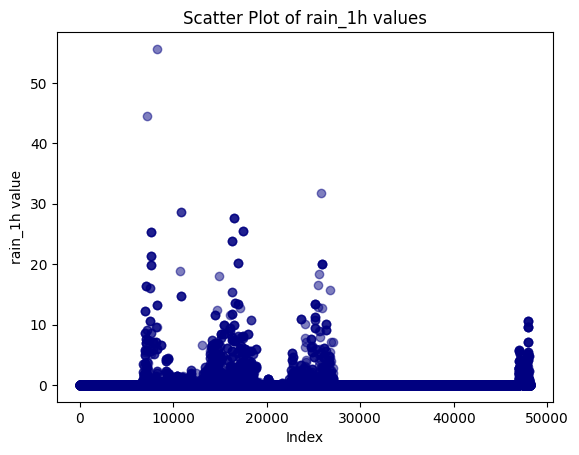

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Replace the value exceeding hourly rain volume greater than 1000
i94_traffic.loc[i94_traffic['rain_1h'] > 1000, 'rain_1h'] = 0.0

# Plotting a scatter plot to visualize rain_1h values after correction
plt.scatter(range(len(i94_traffic['rain_1h'])), i94_traffic['rain_1h'], color='navy', alpha=0.5)
plt.title('Scatter Plot of rain_1h values')
plt.xlabel('Index')
plt.ylabel('rain_1h value')
plt.show()

After removing the outlier, we observe a more accurate distribution of rain volume.

Other numerical columns such as `snow_1h`, `clouds_all`, `date_time`, and `temp` exhibit consistency and reflect data integrity. Therefore, we will omit the details of this process from the report to conserve space.

## Exploration: Unveiling Traffic Volume Patterns

In this exploration phase, we delve into the distribution of key columns in determining pivotal traffic trends.

To uncover high traffic patterns, we'll focus on the following:

1. **Traffic Volume Distribution:** We'll examine the distribution of traffic volume, pursuing any leads that may guide our analysis.

2. **Temporal Traffic Analysis:** We'll dissect traffic patterns across various timeframes such as hourly, weekly, and monthly, while distinguishing between daytime vs nighttime traffic and business days vs weekends.

3. **Finding Correlations:** We investigate potential correlations between traffic volume and various environmental factors such as weather conditions, holidays, and temperature indicators. Strong correlations will be further investigated to understamd the underlying relationships.

### I. Visualize Traffic Volume Distribution

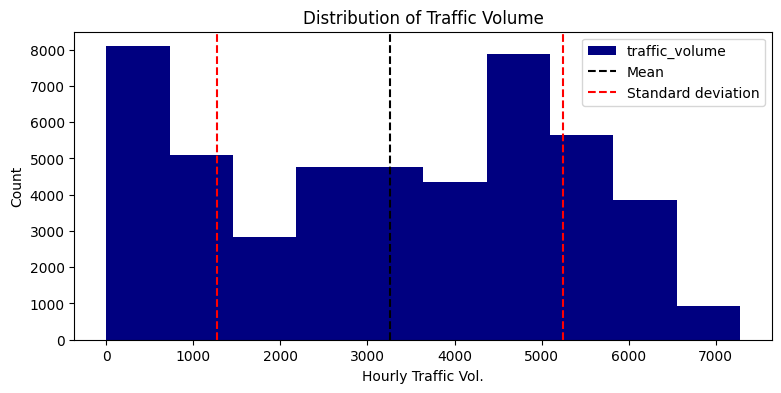

In [14]:
traffic_vol = i94_traffic['traffic_volume']
st_dev = traffic_vol.std(ddof = 0)
mean = traffic_vol.mean()

# Visualize the distribution of traffic volume in a histogram
traffic_vol.plot.hist(figsize=(9, 4), xlabel='Hourly Traffic Vol.', ylabel='Count', title='Distribution of Traffic Volume', color='navy')
plt.axvline(mean, color = 'black', linestyle='--', label = 'Mean')
plt.axvline(mean + st_dev, color = 'red', linestyle='--', label = 'Standard deviation')
plt.axvline(mean - st_dev, color = 'red', linestyle='--')
plt.legend()

plt.show()


In [15]:
# Generate key insights about traffic volume
traffic_vol.describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

**Observations:**

* Bewteen 2012 to 2018, the traffic ranged from *0 vehicles to 7,280 vehicles* per hour. The highest count is concentrated between *0-500* vehicles (8000 count) and *4,500-5,000* vehicles (8000 count), with the overall ***average*** of *3,260* vehicles.

* Approximately **25%** of the time, the traffic volume remained at 1,193 vehicles or fewer per hour. This suggests a probable dominance of nighttime traffic during these periods.

* At the **75th percentile**, the traffic volume remained at 4,933 vehicles or fewer per hour, indicating that three-quarters of the time, the traffic volume was within this range. Conversely, the **remaining 25%** of instances witnessed traffic exceeding 4,933 vehicles per hour.

The possibility of varying nighttime and daytime traffic could add an interesting perspective to our analysis.

### Exploration: Comaparing Nightime and Daytime Traffic
To facilitate a nuanced analysis, we partitioned the dataset into two distinct segments:

* **Daytime Data:** Comprising hours from 7 a.m. to 7 p.m. (12 hours).
* **Nighttime Data:** Encompassing hours from 7 p.m. to 7 a.m. (12 hours).

*Note: The `date_time` column has been formatted during the cleaning phase to derive meaningful time-based analysis.*

In [16]:
import datetime as dt

date_col = i94_traffic['date_time']

# Create a boolean for daytime data selection: [7:00:00. - 19:00:00)
daytime_bool = (date_col.dt.time >= dt.time(7, 0, 0)) & (date_col.dt.time < dt.time(19, 0, 0))

# Create a new column to represent time of the day
i94_traffic['time_of_day'] = ''
i94_traffic.loc[daytime_bool, 'time_of_day'] = 'Daytime'

i94_traffic.loc[daytime_bool, 'date_time'].dt.time.value_counts().sort_index()

date_time
07:00:00    2079
08:00:00    2080
09:00:00    2018
10:00:00    2078
11:00:00    1952
12:00:00    1955
13:00:00    1905
14:00:00    1969
15:00:00    1934
16:00:00    1988
17:00:00    1933
18:00:00    1986
Name: count, dtype: int64

In [17]:
# Create a boolean for nighttime data selection: [00:00:00 - 7:00:00) or [19:00:00 - 23:00:00]
nighttime_bool = (date_col.dt.time >= dt.time(19, 0, 0)) | (date_col.dt.time < dt.time(7, 0, 0))

# Add value to the new column based on boolean selection
i94_traffic.loc[nighttime_bool, 'time_of_day'] = 'Nighttime'

i94_traffic.loc[nighttime_bool, 'date_time'].dt.time.value_counts().sort_index()

date_time
00:00:00    2037
01:00:00    2049
02:00:00    2019
03:00:00    2025
04:00:00    2091
05:00:00    2063
06:00:00    2087
19:00:00    1961
20:00:00    1979
21:00:00    1982
22:00:00    1994
23:00:00    2040
Name: count, dtype: int64

**Visualize Nighttime and Daytime Traffic Distribution:**

Now that we've isolated day and night dataset, we will look at the traffic volume side-by-side by superimposing the histograms.

c:\Users\shree\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


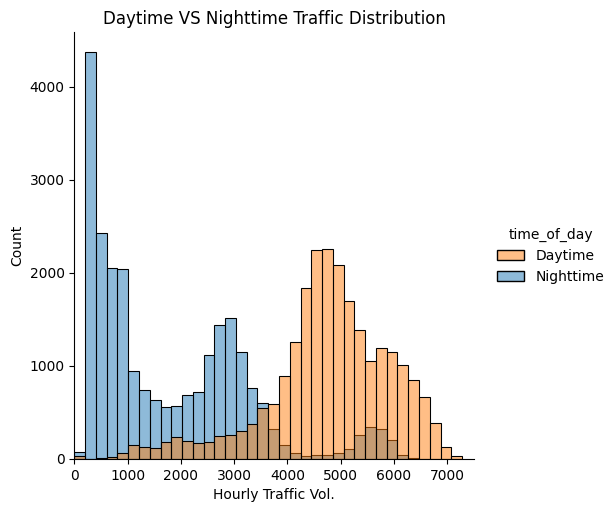

In [18]:
import seaborn as sns

# Get all colors from tab10 color palette for color mapping
palette_colors = sns.color_palette('tab10')
color_map = {'Daytime': palette_colors[1], 
             'Nighttime': palette_colors[0]
            }

# Plot a historgram to compare the day and night dataset's distributions
sns.displot(data=i94_traffic, x="traffic_volume", hue="time_of_day", palette=color_map)

plt.title('Daytime VS Nighttime Traffic Distribution')
plt.xlabel('Hourly Traffic Vol.')
plt.ylabel('Count')
plt.xlim(0, 7500)

plt.show()

In [19]:
# Generate insights for daytime traffic
i94_traffic.loc[daytime_bool, 'traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [20]:
# Generate insights for nighttime traffic
i94_traffic.loc[nighttime_bool, 'traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

**Observations:**

The nighttime traffic exhibits a **right-skewed distribution**, with **75%** of hourly traffic volumes less than or equal to *2,819*. In contrast, daytime traffic demonstrates a nearly **normal distribution**, with a substantial concentration observed between *4,500 and 5,000* vehicles, and **50%** of the time experiencing traffic volumes exceeding *4,820* vehicles per hour. Notably, nighttime traffic volumes **range** from **0 to 6,386**, significantly narrower compared to daytime traffic, which spans from **0 to 7,280** vehicles per hour.

Given our objective of identifying indicators of high traffic, the distribution of daytime traffic appears promising. Consequently, we will isolate the daytime traffic dataset for a focused analysis moving forward.

In [21]:
# Isolate daytime traffic from the original dataset based on the daytime boolean criteria
daytime_traffic = i94_traffic.copy().loc[daytime_bool]

### II. Temporal Traffic Volume Analysis

 Time serves as a crucial indicator of heavy traffic patterns, with variations observed across different months, days of the week, and between business days and weekends. We'll investigate these temporal trends through a series of line plots, examining how traffic volume changes according to the following parameters:

1. **Month:** Traffic fluctuations over each month, inlcuding warmer versus colder month comparision.
2. **Day of the Week:** Traffic volume variations throughout the week: Monday-Sunday.
3. **Hourly Traffic Trends between Business Days and Weekend:** Compare traffic trends between business days and weekends to uncover distinctive hourly patterns.

Before we begin, we'll write a quick function that will group a dataset by a given column, calculate the mean, and visualize the average traffic by the grouped column.

In [22]:
# Function to group and visualize a plot line by the parameter passed
def group_and_visualize(col_name, dataset):
    
    # Group the dataset by month to get monthly traffic average
    mean_by_col = dataset.pivot_table(values='traffic_volume', index=col_name, aggfunc='mean')

    # Visualize the monthly avergae in a line chart
    mean_by_col['traffic_volume'].plot.line(color='navy')
    
    plt.ylabel('Traffic Vol.')
    plt.axhline(dataset['traffic_volume'].mean(), label='mean', color='black', linestyle='--')
    plt.legend()

    return mean_by_col

**1. Monthly Traffic Patterns**:

We'll start by extracting the month from the `date_time` column. We'll then group the dataset by month and calculate the avaerage for each month. Finally, we'll visualize by plotting a line chart.

In [23]:
# Extract the month from date_time column
daytime_traffic['month'] = daytime_traffic['date_time'].dt.month

# Verify the new month column data
daytime_traffic.loc[5000:7500,['date_time', 'month']]

,date_time,month
5000,2013-04-11 14:00:00,4
5001,2013-04-11 15:00:00,4
5002,2013-04-11 16:00:00,4
5003,2013-04-11 17:00:00,4
5004,2013-04-11 18:00:00,4
...,...,...
7496,2013-07-07 12:00:00,7
7497,2013-07-07 13:00:00,7
7498,2013-07-07 14:00:00,7
7499,2013-07-07 15:00:00,7


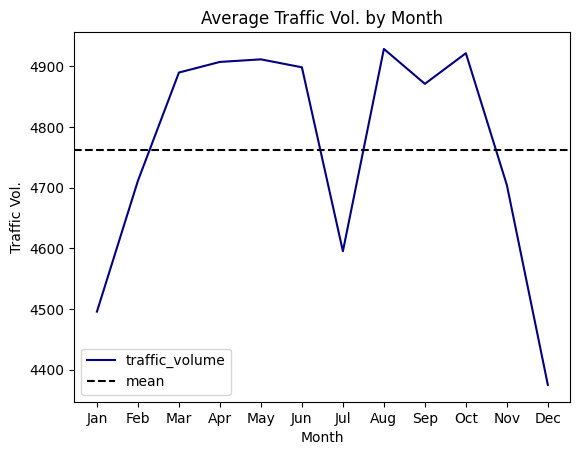

In [24]:
# Group the dataset by month and visualize the monthly avergae in a line chart
mean_by_month = group_and_visualize('month', daytime_traffic)

# Customize the line chart
plt.xticks(mean_by_month.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Average Traffic Vol. by Month')
plt.xlabel('Month')

plt.show()


**Observations:**

* During the *winter months* (November through February), the average traffic volume tends to decrease, with the lowest traffic observed in December.
* Conversely, the *warmer months* (March through October) typically experience higher average traffic volumes.

*Exception:* Interestingly, despite being one of the warmer months, July stands out with a notable decrease in average traffic volume. This divergence prompts further investigation into potential contributing factors. To gain deeper insights, we'll plot yearly traffic trends specifically for July.

**Investigating the July Traffic Plunge:**

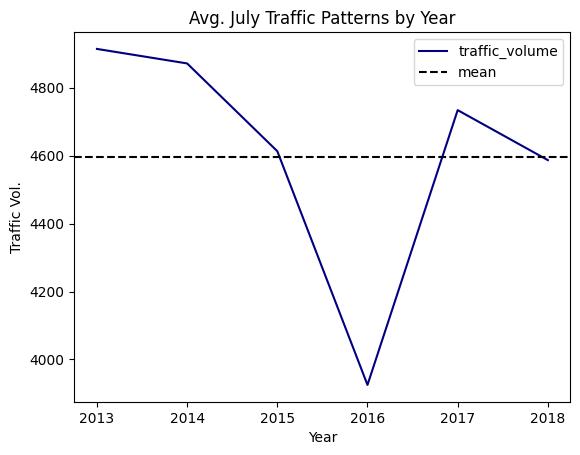

In [62]:
# Extract year from the date_time column
daytime_traffic['year'] = daytime_traffic.copy()['date_time'].dt.year

# Isolate the July traffic data from the dataset
july_traffic = daytime_traffic[daytime_traffic['month'] == 7]

# Group the dataset by year and visualize the July averages in a line chart
group_and_visualize('year', july_traffic)

# Customize chart
plt.title('Avg. July Traffic Patterns by Year')
plt.xlabel('Year')

plt.show()

In [56]:
from math import ceil

# Isolate warmer months (March - October)
warmer_months = daytime_traffic[daytime_traffic['month'].between(3, 10)]

# Create July 2016 Boolean
july_2016_bool = (warmer_months['year'] == 2016) & (warmer_months['month'] == 7)

ceil(warmer_months.loc[~july_2016_bool, 'traffic_volume'].mean())

4883

Typically, July experiences heavy traffic similar to other warm months. However, an exception occurred in **2016**, marked by a significant decrease in traffic volume. External factors, such as construction work during that period, likely contributed to this deviation from the expected traffic patterns.

In general, warm months exhibit heavier traffic compared to colder months, with an average traffic volume close to **4,883 cars per hour** after excluding July 2016 traffic.

**2. Day of the Week Traffic Trends:**

Moving beyond monthly variations, we'll now delve into another temporal unit of analysis: the day of the week.

In [57]:
# Extract day of the week from the date_time column
daytime_traffic['dayofweek'] = daytime_traffic['date_time'].dt.dayofweek

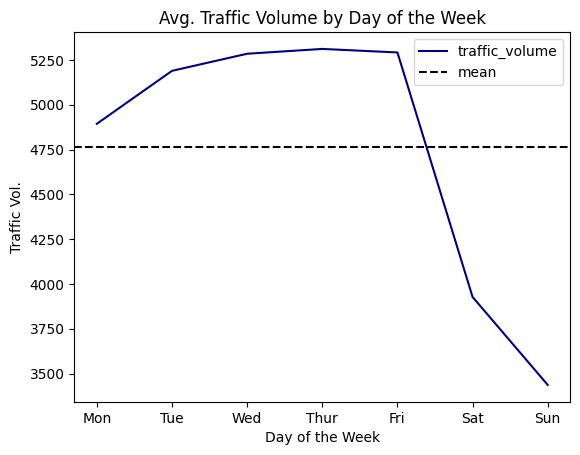

In [63]:
# Group the dataset by year and visualize the July averages in a line chart
mean_by_dayofweek = group_and_visualize('dayofweek', daytime_traffic)

# Customize the line chart
plt.xticks(mean_by_dayofweek.index, ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.title('Avg. Traffic Volume by Day of the Week')
plt.xlabel('Day of the Week')

plt.show()

**Observations:**

* **Business Days:** On average, traffic volume is notably higher during business days (Monday-Friday), reaching its peak on Friday.
* **Weekends:** Conversely, traffic experiences a significant decline during the weekend (Saturday and Sunday), maintaining lighter levels with values consistently below *4,000 vehicles per hour*, compared to the average traffic volume of *4,762 vehicles per hour*.

**3. Comparing Hourly Traffic Trends between Business Days and Weekend:**

To analyze hourly traffic trends effectively, we'll generate separate line plots for business days and weekends. This approach ensures that the distinct patterns of each category are accurately represented without the influence of the other. 

We'll begin by extracting the hour from the dataset and splitting the dataset into two.

In [65]:
# Extract hour from date_time column
daytime_traffic['hour'] = daytime_traffic['date_time'].dt.hour

# Separate the business days traffic from the dataset
weekdays_traffic = daytime_traffic[daytime_traffic['dayofweek'] <= 4]

# Separate the weekend traffic from the dataset
weekend_traffic = daytime_traffic[daytime_traffic['dayofweek'] >= 5]

Now, we'll group each of the split datasets by hour and calculate the mean to compare the average hourly traffic volume side-by-side between the two datasets using a *grid chart*.

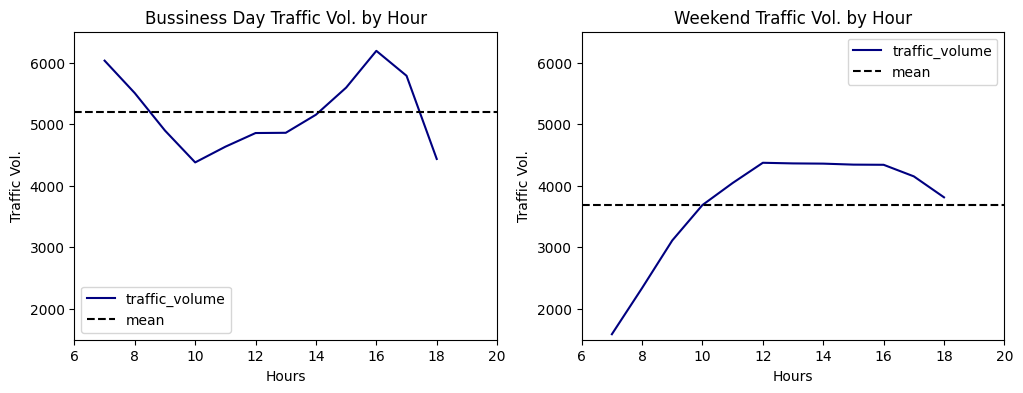

In [75]:
plt.figure(figsize=(12, 4))

# Plot the 1st subplot
plt.subplot(1, 2, 1)

# Group the dataset by hour and visualize the average traffic volume for business days in a line chart
weekdays_hourly_traffic = group_and_visualize('hour', weekdays_traffic)

# Customization of business days line chart
plt.title('Bussiness Day Traffic Vol. by Hour')
plt.xlabel('Hours')
plt.xlim(6, 20)
plt.ylim(1500,6500)

# Plot the 2nd subplot
plt.subplot(1, 2, 2)

# Group the dataset by hour and visualize the average traffic volume for business days in a line chart
weekend_hourly_traffic = group_and_visualize('hour', weekend_traffic)

# Customization of weekend line chart
plt.title('Weekend Traffic Vol. by Hour')
plt.xlabel('Hours')
plt.xlim(6, 20)
plt.ylim(1500,6500)

plt.show()

In [78]:
weekdays_hourly_traffic.describe()

,traffic_volume
count,12.000000
mean,5192.498812
std,615.622781
min,4378.419118
25%,4799.891475
50%,5024.132518
75%,5640.880110
max,6189.473647


In [79]:
weekend_hourly_traffic.describe()

,traffic_volume
count,12.000000
mean,3709.128440
std,911.307344
min,1589.365894
25%,3542.880206
50%,4098.037442
75%,4346.478609
max,4372.482883


**Observations:**

- **Business Days:** Traffic volume remains consistently high from *6 AM to 6 PM*, with notable peaks during rush hours at *6 AM and 5 PM*. This likely corresponds to the morning and evening work commutes. During these peak periods, traffic volumes surpass *6,000 vehicles per hour*. However, there's a comparative decrease in traffic during the late morning and early afternoon hours, between *10 AM to 2 PM*. On average, business days witness approximately *5,193 vehicles per hour*.
  
- **Weekend Traffic:** On weekends, traffic peaks during mid-day hours from *12 PM to 4 PM* and maintains a relatively constant level throughout the day. Conversely, there's notably less traffic during the early morning hours from *6 AM to 10 AM*. On avergae, the weekend traffic is relatively low at *3,709 vehicles*.

### III. Exploring the Relationship Between Traffic Volume and Other Indicators

Within our dataset, we have insightful columns detailing weather conditions such as `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, and `weather_description` and U.S. holidays (`holiday`). 

1. **Numerical Weather Data:** Some of these columns are *numerical* categories. Our initial analysis will involve calculating *Pearson's Correlation Coefficient* between these weather variables and traffic volume to identify any significant correlations. 
2. **Categorical Weather Data:** Following this, we'll delve into the categorical weather data to identify strong indicators.
3. **Holidays:** Additionally, we will analyze holiday information to discern its impact on high traffic volume.

**1. Pearson's Correlations between Traffic Volume and Numerical Weather Columns:**

*Note:* [Pearson's r](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) values lie between *-1.00 and +1.00*. When the positive correlation is perfect, the Pearson's r is equal to *+1.00*. When the negative correlation is perfect, the Pearson's r is equal to *-1.00*. A value of *0.0* shows no correlation.

In [80]:
# Extract only the weather related columns
weather_traffic = daytime_traffic.copy()[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']]

# Calculate Pearson's correlation between the numerical columns and traffic volume
weather_traffic.corr()['traffic_volume']

temp              0.128317
rain_1h          -0.040631
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

While none of the numerical columns exhibit a notably strong correlation with traffic volume, `temp` shows a slight *positive correlation* (**+0.128317**), though it appears to lack reliability as an indicator.

To visually explore correlations, a scatter plot offers an effective tool. We'll create one to assess the strength of the relationship with `temp`. We'll add `weather_main` to add a new perspective.

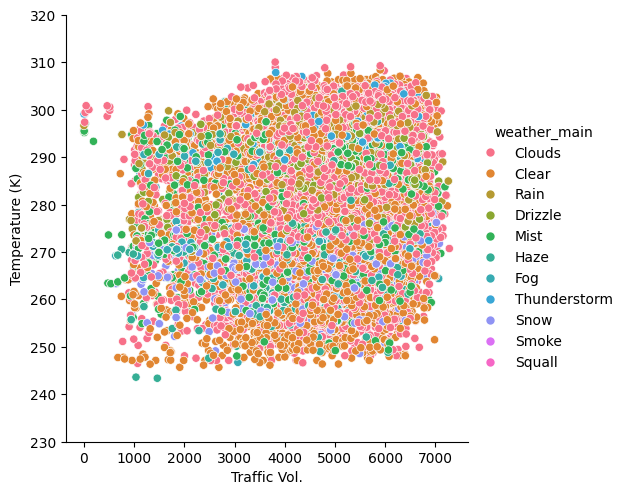

In [93]:
# Visualize a scatter plot between temperature and traffic volume
sns.relplot(data=daytime_traffic, x="traffic_volume", y="temp", hue='weather_main', color='navy')

plt.xlabel('Traffic Vol.')
plt.ylabel('Temperature (K)')
plt.ylim(230, 320)

plt.show()

Looking at the scatter plot, we can conclude that temperature is not a solid traffic indicator. There is no clear pattern with `weather_main` in relation to temperature or traffic volume either.

**2. A Closer Look at the Categorical Weather Indicators:**

Having previously examined `weather_main` alongside temperature and traffic volume in a scatter plot, we'll now focus on a separate analysis of this variable to discern its individual relationships with traffic volume, along with another categorical weather indicator: `weather_description`.

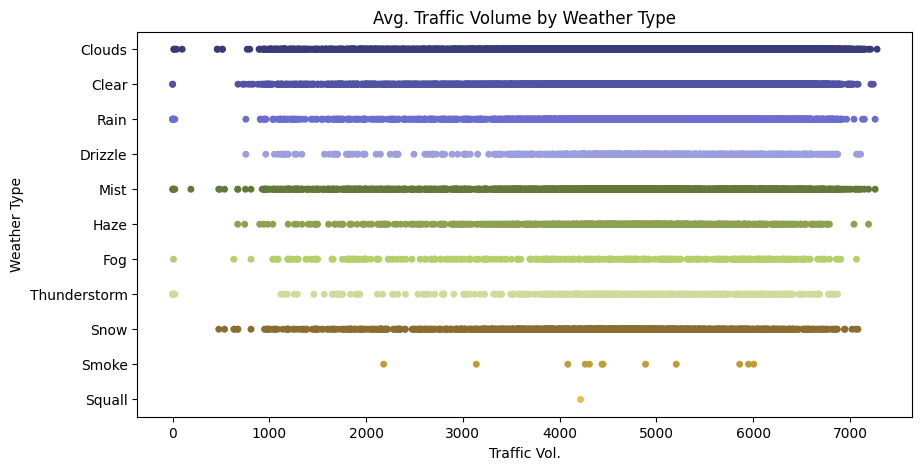

In [116]:
# Plot a stripplot between traffic_volume and weather_main
plt.figure(figsize=(10, 5))
sns.stripplot(data=daytime_traffic, x='traffic_volume', y='weather_main', jitter=False, palette='tab20b', hue='weather_main', legend=False)

plt.title('Avg. Traffic Volume by Weather Type')
plt.xlabel('Traffic Vol.')
plt.ylabel('Weather Type')

plt.show()

The analysis reveals no distinct patterns among weather types associated with higher traffic volume. Their distribution appears similar, except for *Smoke* and *Sqall* categories, which have fewer data points overall. 

The reasons behind high traffic volume during adverse weather conditions remain unclear. This lack of clarity complicates the identification of reliable indicators for heavy traffic.

**A Granular Look at the Weather Description:**

To address the issue, we'll adopt a more detailed approach by grouping the dataset according to `weather_description`. This variable offers a more nuanced description of weather conditions and allows for a finer classification of weather events. Specifically, we'll look at the **top 10** highest traffic average by weather description .

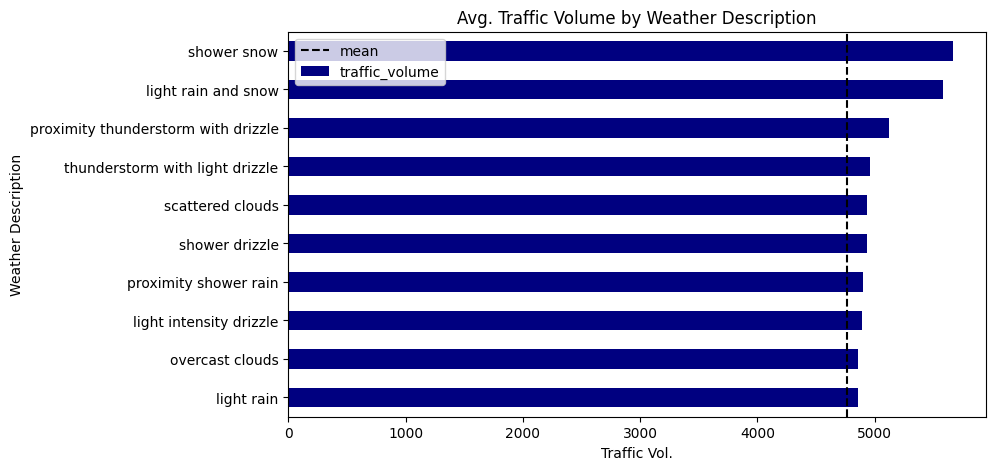

In [146]:
# Get traffic average by weather description
mean_by_weather_desc = daytime_traffic.pivot_table(values='traffic_volume', index='weather_description', aggfunc='mean')

# Get the top 10 highest traffic average by weather description
top_10_weather_ind = mean_by_weather_desc['traffic_volume'].sort_values(ascending=False)[:10]

# Visualize the average traffic patterns by plotting a bar chart
plt.figure(figsize=(9, 5))
top_10_weather_ind.sort_values().plot.barh(xlabel='Traffic Vol.', ylabel='Weather Description', color='navy')

plt.title('Avg. Traffic Volume by Weather Description')
plt.axvline(daytime_traffic['traffic_volume'].mean(), color='black', label='mean', linestyle='--')
plt.legend(loc='upper left')

plt.show()

It appears that three weather types—**Shower snow**, **Light rain and snow**, and **Proximity thunderstorm** with drizzle—exhibit average traffic volumes exceeding **5,000**. While these weather conditions are adverse, they might not be severe enough to deter significant numbers of motorists, given that all of them surpass the mean traffic volume of 4,762.

# Closer look at holiday column

In [39]:
i94_traffic['holiday'].value_counts()

holiday
None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

In [40]:
# Holiday Boolean
holiday_bool = ~(i94_traffic['holiday'] == 'None')

#Exclude None
holiday_traffic = i94_traffic[holiday_bool]

holiday_traffic['holiday'].value_counts()

holiday
Labor Day                    7
Thanksgiving Day             6
Christmas Day                6
New Years Day                6
Martin Luther King Jr Day    6
Columbus Day                 5
Veterans Day                 5
Washingtons Birthday         5
Memorial Day                 5
Independence Day             5
State Fair                   5
Name: count, dtype: int64

<Axes: xlabel='holiday', ylabel='traffic_volume'>

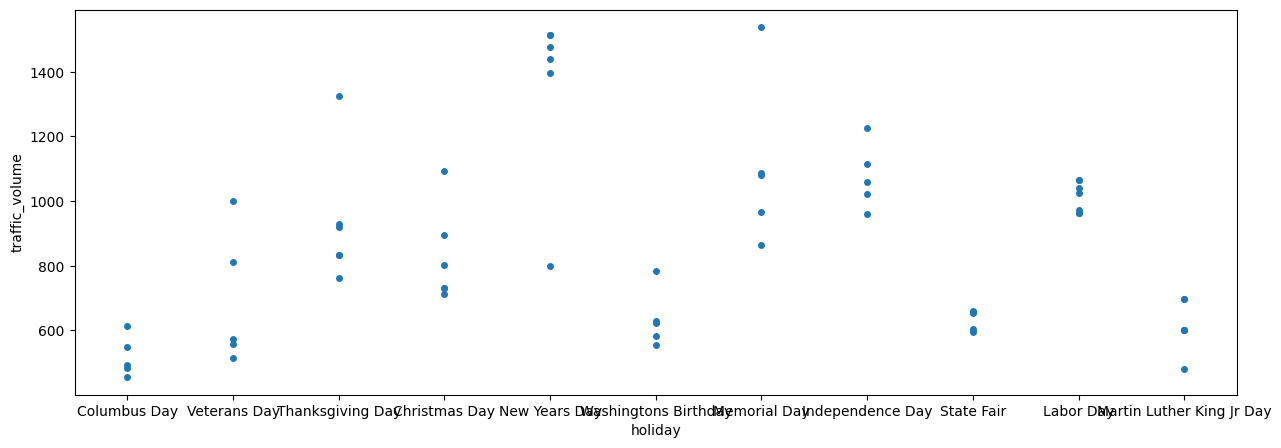

In [41]:
plt.figure(figsize=(15, 5))
sns.stripplot(x='holiday', y='traffic_volume', data=holiday_traffic, jitter=False)

<Axes: ylabel='holiday'>

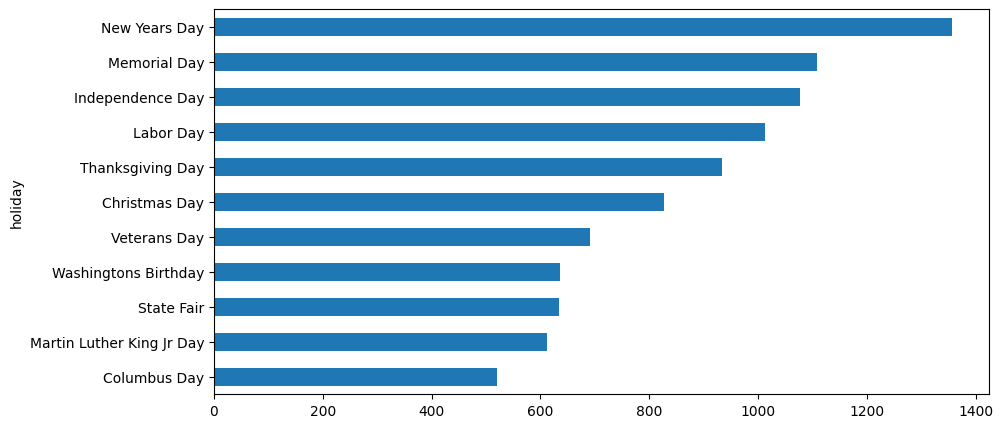

In [42]:
mean_by_holidays = holiday_traffic.pivot_table(values='traffic_volume', index='holiday', aggfunc='mean')

plt.figure(figsize=(10, 5))
mean_by_holidays['traffic_volume'].sort_values().plot.barh()

Highest during New Year's day, while still relatively low (1400 avg count). Memorial day and Independece Day come close at 2nd and 3rd. While Thanksgiving and Christmas stayed relatively mild. 

# Conclusion

In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:
**Summary of Time-based Indicators:**

* Daytime traffic has higher count than nighttime traffic.
* Warmer months have generally higher traffic volume, compared to lowest in the colder months (Dec).
* On Avergae, weekend are lighter and business days are heavier.
* Rush hours on business days are: xxx while weekends are yyy.  

Time indicators
The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
The traffic is usually heavier on business days compared to the weekends.
On business days, the rush hours are around 7 and 16.
Weather indicators
Shower snow
Light rain and snow
Proximity thunderstorm with drizzle
Next steps include the following:

Use the nighttime data to look for heavy traffic indicators.
Find more time and weather indicators.
Make your project portfolio-ready by following this style guide.
Find more time and weather indicators.
Make your project portfolio-ready by following this style guide.

Holidays like New Year's, Memorial day, and Independnece day saw higher I-94 traffic.